In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# 1. Відкрити та зчитати наданий файл з даними.
# 2. Визначити та вивести кількість записів.
# 3. Вивести атрибути набору даних.

df = pd.read_csv('dataset3_l4.csv')
df.columns = df.columns.str.strip()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [3]:
# Визначається список категоріальних стовпців
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

# Створюються екземпляри LabelEncoder і OneHotEncoder
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder()

# Останній стовпчик не враховується бо це цільова характеристика
for col in categorical_columns[:-1]:
    unique_count = df[col].nunique()
    # Якщо унікальних значень два то застосовується LabelEncoder для перетворення значень на числові (0 або 1)
    if unique_count == 2:
        df[col] = label_encoder.fit_transform(df[col])
    # Інакше застосовується OneHotEncoder для створення додаткових стовпців з бінарними показниками для кожного унікального значення категорії
    else:
        encoded_df = pd.DataFrame(onehot_encoder.fit_transform(df[[col]]).toarray(), columns=onehot_encoder.get_feature_names_out([col]))
        df = pd.concat([df, encoded_df], axis=1)
        df.drop(columns=[col], inplace=True)

['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']


In [4]:
# Ввести з клавіатури кількість варіантів перемішування (не менше
# трьох) та отримати відповідну кількість варіантів перемішування
# набору даних та розділення його на навчальну (тренувальну) та тестову
# вибірки, використовуючи функцію ShuffleSplit. Сформувати навчальну
# та тестову вибірки на основі другого варіанту. З’ясувати
# збалансованість набору даних.


# n_splits = int(input("Кількість варіантів перемішування (не менше трьох)"))
n_splits = 10

# При кожній ітерації ShuffleSplit створює новий набір випадкових індексів, які потім використовуються для розбиття даних на навчальний та тестові набори
ss = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)

for i, (train_index, test_index) in enumerate(ss.split(df)):
    if i == 1:
        train_set = df.iloc[train_index]
        test_set = df.iloc[test_index]
        break

df["NObeyesdad"].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

In [5]:
# Використовуючи функцію KNeighborsClassifier бібліотеки scikit-learn,
# збудувати класифікаційну модель на основі методу k найближчих
# сусідів (значення всіх параметрів залишити за замовчуванням) та
# навчити її на тренувальній вибірці, вважаючи, що цільова
# характеристика визначається стовпчиком NObeyesdad, а всі інші
# виступають в ролі вихідних аргументів.

X_train, X_test = train_set.drop("NObeyesdad", axis=1), test_set.drop("NObeyesdad", axis=1)
y_train, y_test = train_set["NObeyesdad"], test_set["NObeyesdad"]

model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

- training set metrics
accuracy: 0.9188388625592417
precision: 0.9222103656412117
recall: 0.9188388625592417
f1 score: 0.9153245356151107

- test set metrics
accuracy: 0.8865248226950354
precision: 0.8930924340136931
recall: 0.8865248226950354
f1 score: 0.8802338205406162



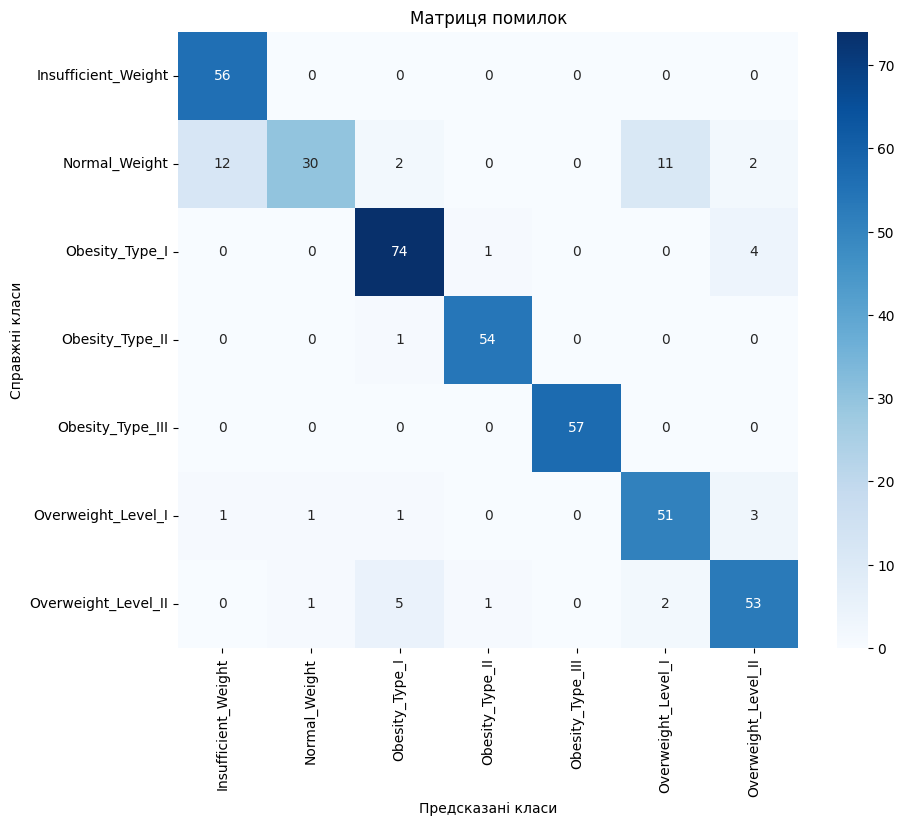

In [6]:
#  Обчислити класифікаційні метрики збудованої моделі для тренувальної
# та тестової вибірки. Представити результати роботи моделі на тестовій
# вибірці графічно.

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

def get_metrics(model, y, y_pred):
    print(f'- {model} set metrics')
    print(f'accuracy: {accuracy_score(y, y_pred)}')
    print(f'precision: {precision_score(y, y_pred, average='weighted', zero_division=0)}')
    print(f'recall: {recall_score(y, y_pred, average='weighted')}')
    print(f'f1 score: {f1_score(y, y_pred, average='weighted')}\n')

get_metrics("training", y_train, y_train_pred)
get_metrics("test", y_test, y_test_pred)

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Предсказані класи')
plt.ylabel('Справжні класи')
plt.title('Матриця помилок')
plt.show()

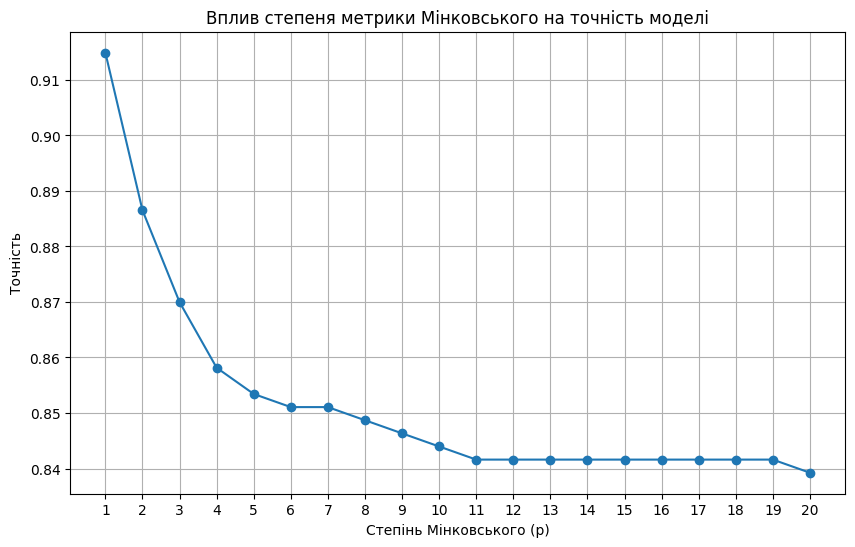

In [7]:
# З’ясувати вплив степеня метрики Мінковського (від 1 до 20) на
# результати класифікації. Результати представити графічно.

p_values = range(1, 21)
# список який буде зберігати точність моделі для кожного значення p
accuracies = []

for p in p_values:
    model = KNeighborsClassifier(p=p)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(p_values, accuracies, marker='o')
plt.title('Вплив степеня метрики Мінковського на точність моделі')
plt.xlabel('Степінь Мінковського (p)')
plt.ylabel('Точність')
plt.xticks(np.arange(1, 21, step=1))
plt.grid(True)
plt.show()